         Country  AveragScore  SafetySecurity  PersonelFreedom  Governance  \
0        Denmark        84.55           92.59            94.09       89.45   
1         Sweden        83.67           90.97            91.90       86.41   
2         Norway        83.59           93.30            94.10       89.66   
3        Finland        83.47           89.56            91.96       90.41   
4    Switzerland        83.42           95.66            87.50       87.67   

   SocialCapital  InvestmentEnvironment  EnterpriseConditions  \
0          82.56                  82.42                 79.64   
1          78.29                  82.81                 75.54   
2          79.03                  82.24                 75.95   
3          77.27                  84.12                 77.25   
4          69.14                  80.81                 83.84   

   MarketAccessInfrastructure  EconomicQuality  LivingConditions  Health  \
0                       78.79            76.81             95.77

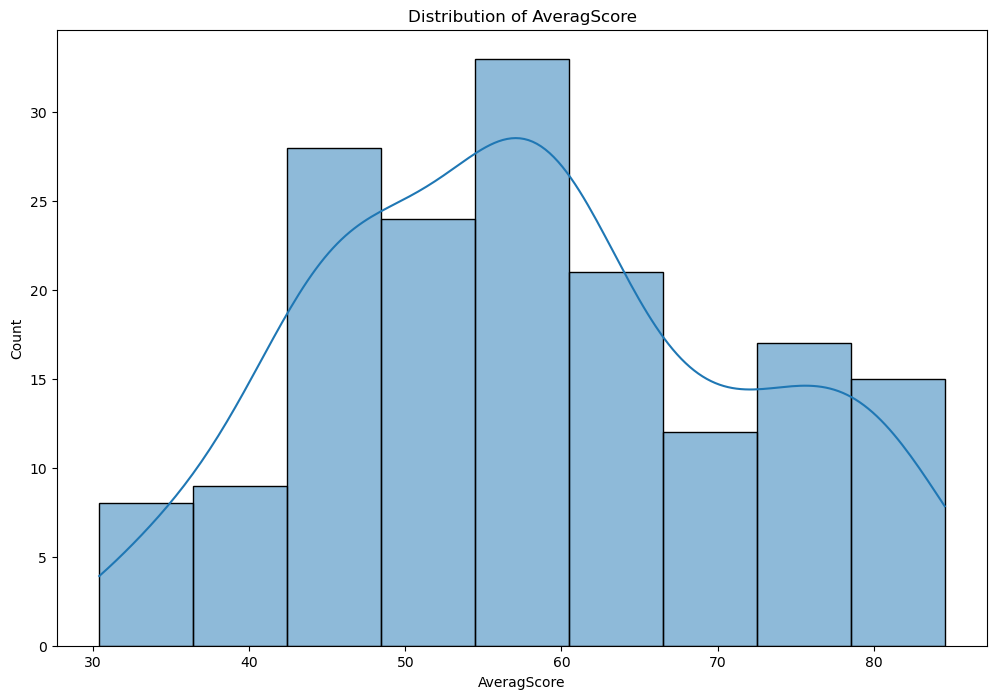

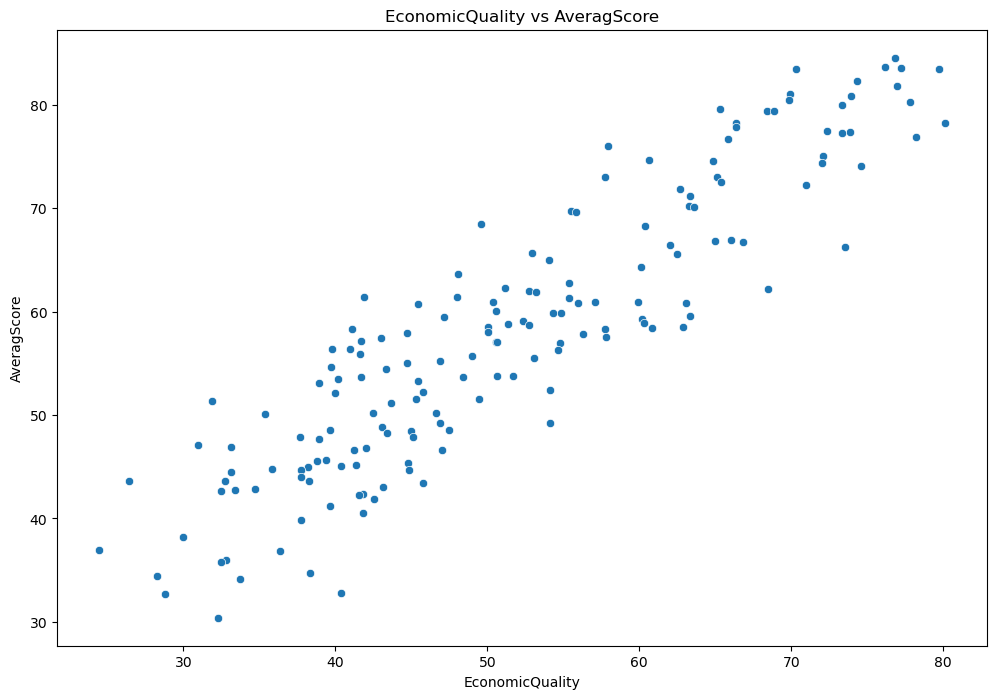

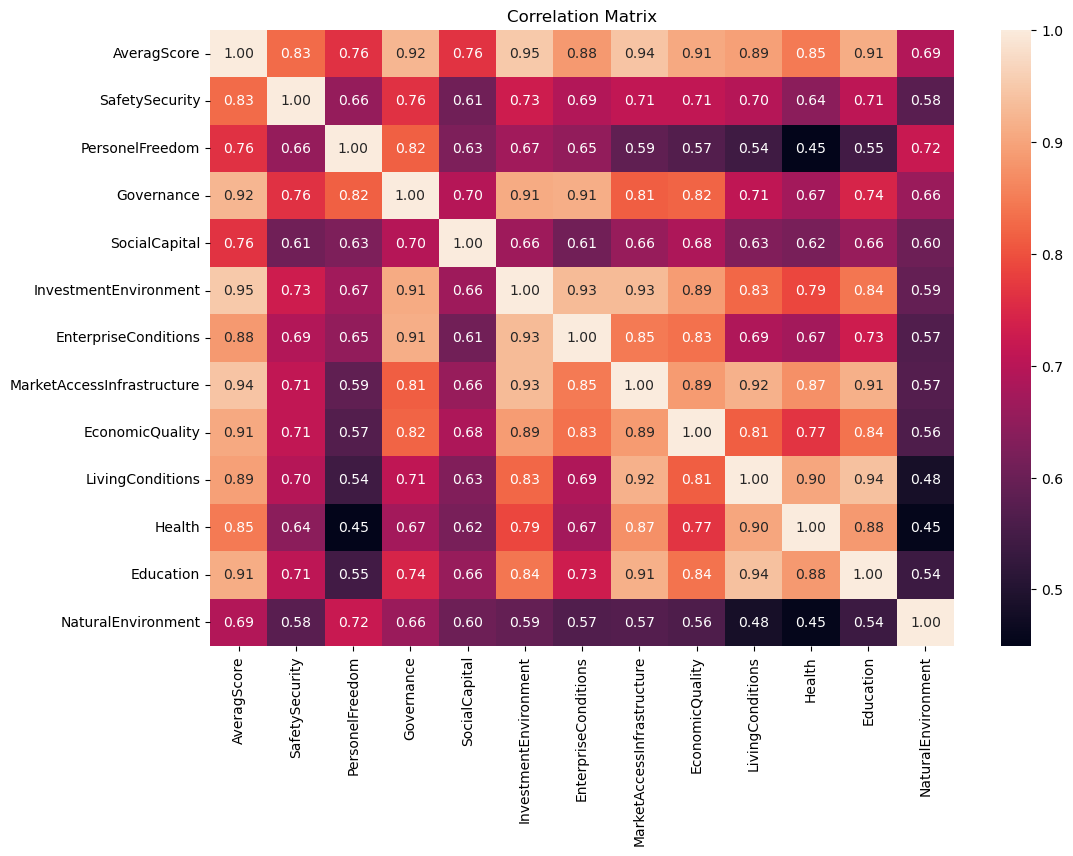

In [1]:
#%% 1. Data Loading and Exploration
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('data.csv')

# Display the first few rows of the dataset
print(data.head())

# Display summary statistics
print(data.describe())

# Check for missing values
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

# Data distribution and relationships, lets pick some of them
# first the Avg score
plt.figure(figsize=(12, 8))
sns.histplot(data['AveragScore'], kde=True)
plt.title('Distribution of AveragScore')
plt.show()

# let see how is that related to EconomicQuality
plt.figure(figsize=(12, 8))
sns.scatterplot(x=data['EconomicQuality'], y=data['AveragScore'])
plt.title('EconomicQuality vs AveragScore')
plt.show()

# finally the correlation matrix between them all
plt.figure(figsize=(12, 8))
corr_matrix = data.iloc[:,1:].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [2]:
#%% 2. Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate target variable and features
data=data.set_index('Country')
X = data.drop('AveragScore', axis=1)
y = data['AveragScore']

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Since all columns are numerical and there is no missing data, we can proceed with scaling
scaler=StandardScaler()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing to the training data
X_train_processed = scaler.fit_transform(X_train)
X_test_processed = scaler.transform(X_test)


In [3]:
#%% 3. Model Building and Evaluation
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize models, lets try some of the most common
models = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor()
}

# Train and evaluate models
results = {}

for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R²': r2}
    print(f"{name}: RMSE = {rmse:.2f}, R² = {r2:.2f}")

# Display results in a table
results_df = pd.DataFrame(results).T
print(results_df)

Decision Tree: RMSE = 4.49, R² = 0.87
Random Forest: RMSE = 2.14, R² = 0.97
Gradient Boosting: RMSE = 1.89, R² = 0.98
XGBoost: RMSE = 2.35, R² = 0.97
                       RMSE        R²
Decision Tree      4.489583  0.872686
Random Forest      2.137156  0.971151
Gradient Boosting  1.894844  0.977322
XGBoost            2.347231  0.965200


In [4]:
#%% 4. Refinement and Hyperparameter Tuning RandomForest
from sklearn.model_selection import GridSearchCV
import joblib

# Hyperparameter tuning for the best model (example with Random Forest)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train_processed, y_train)

best_model_rndmFor = grid_search.best_estimator_
y_pred = best_model_rndmFor.predict(X_test_processed)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Best Random Forest: RMSE = {rmse:.2f}, R² = {r2:.2f}")
print("Best parameters:", grid_search.best_params_)

# Save the best model to a .pkl file
joblib.dump(best_model_rndmFor, 'best_model_rndmFor.pkl')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Random Forest: RMSE = 1.99, R² = 0.98
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


['best_model_rndmFor.pkl']

In [5]:
#%% Refinement and Hyperparameter Tuning GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import joblib

# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
}

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Setup the grid search with cross-validation
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train_processed, y_train)

# Get the best model from the grid search
best_gbr_model = grid_search.best_estimator_

# Predict on the test data using the best model
y_pred = best_gbr_model.predict(X_test_processed)

# Evaluate the best model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Best Gradient Boosting: RMSE = {rmse:.2f}, R² = {r2:.2f}")
print("Best parameters:", grid_search.best_params_)

# Save the best model to a .pkl file
joblib.dump(best_gbr_model, 'best_gradient_boosting_model.pkl')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Gradient Boosting: RMSE = 1.84, R² = 0.98
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


['best_gradient_boosting_model.pkl']

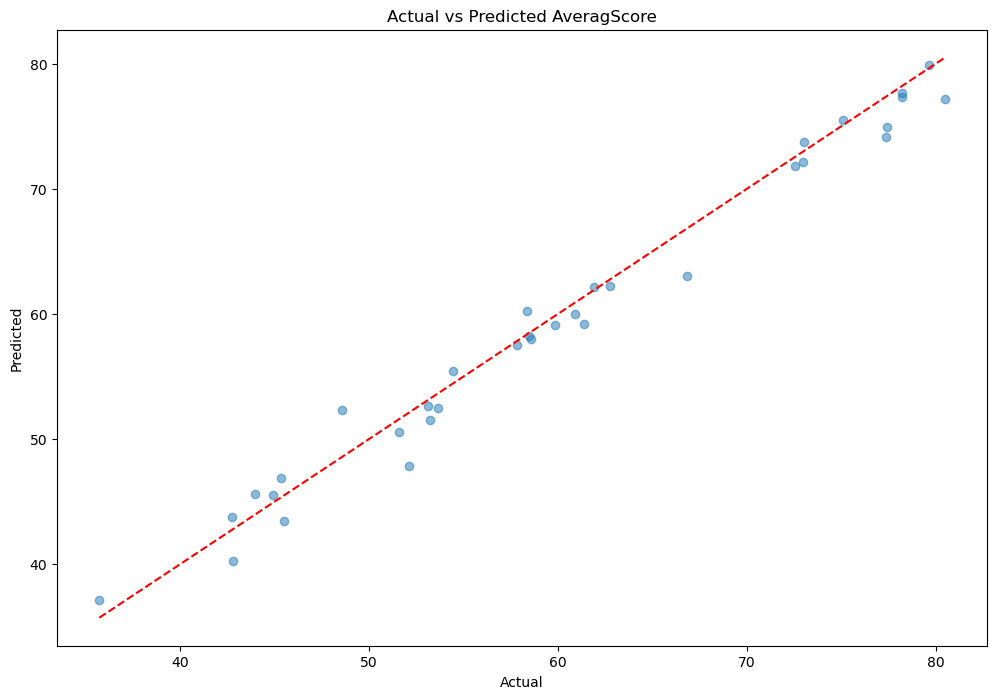

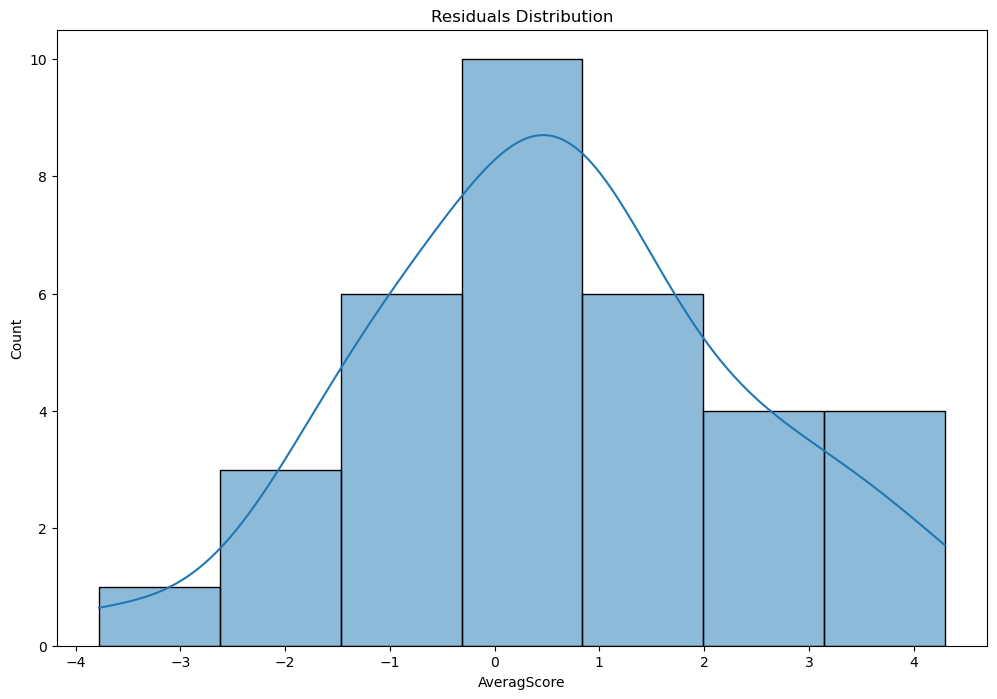

In [6]:
#%% 5. Visualization and Conclusion

# Visualize actual vs predicted prosperity index
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted AveragScore')
plt.show()

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(12, 8))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()
